### Model loading

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import os
import sys
sys.path.append('/global/home/hpc5434/multimodal/Spec/TabSS')

def find_binary_columns(df):
    binary_columns = []
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        if len(unique_values) == 2:
            binary_columns.append(column)
    return binary_columns

def find_continuous_columns(df):
    continuous_columns = []
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        if len(unique_values) > 2:
            continuous_columns.append(column)
    return continuous_columns
from sklearn.base import BaseEstimator, TransformerMixin

# Custom scaler that ignores NaN values
class NaNIgnoringScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        self.mean_ = np.nanmean(X, axis=0)
        self.scale_ = np.nanstd(X, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
# Load datasets
view1 = pd.read_csv('~/multimodal/data/view1.csv').drop(columns=["Unnamed: 0", "fev075fvc_z_score_preBD1"])
view3 = pd.read_csv('~/multimodal/data/view3.csv').drop(columns=["Unnamed: 0", "fev075fvc_z_score_preBD1"])
lung_func_df = pd.read_csv("/global/project/hpcg1553/DUAN_LAB_DATABASE/CHILD_STUDY_DATA/CHILD_HEALTH/lung_function_updated.csv")

# Merge datasets
two_view = view1.merge(view3, on="FID", how="outer")
dataset = lung_func_df[["FID", "fev075fvc_z_score_preBD1"]].merge(two_view, on="FID")

# Split into train and test
test_FID = pd.read_csv("~/multimodal/data/2_view_test.csv")["FID"]
test_dataset = dataset[dataset["FID"].isin(test_FID)].drop(columns="FID")
train_dataset = dataset[~dataset["FID"].isin(test_FID)].drop(columns="FID")

# Prepare data
X_train = train_dataset.drop(columns=["fev075fvc_z_score_preBD1"]).values
y_train = train_dataset["fev075fvc_z_score_preBD1"].values
X_val = test_dataset.drop(columns=["fev075fvc_z_score_preBD1"]).values
y_val = test_dataset["fev075fvc_z_score_preBD1"].values

#scaling
scaler = NaNIgnoringScaler()
indices_to_exclude = find_binary_columns(pd.DataFrame(X_train))
mask = np.array([i for i in range(X_train.shape[1]) if i not in indices_to_exclude])
X_train_transformed = scaler.fit_transform(X_train[:, mask], y_train)
X_train[:, mask] = X_train_transformed
#On X and y test
X_val_transformed= scaler.transform(X_val[:, mask])
X_val[:, mask] = X_val_transformed
########### setting the model up for dice_ml to use
# Remove 'FID' so that DiCE sees only features + outcome
dataset_for_dice = dataset.drop(columns=["FID"]).astype(np.float32)

# Identify categorical vs. continuous features by dropping the outcome column
temp_feats = dataset_for_dice.drop(columns=["fev075fvc_z_score_preBD1"])
cat_feat = find_binary_columns(temp_feats)
cont_feat = find_continuous_columns(temp_feats)

# Convert X_train tensor back to a DataFrame with the correct column names
X_train_df = pd.DataFrame(X_train, columns=temp_feats.columns)

X_val_df = pd.DataFrame(X_val, columns=temp_feats.columns)

In [2]:


from TabSS import TabShaSpec, TabShaSpecWrapper

seed=6
#set random seed
torch.manual_seed(seed)
np.random.seed(seed)

# Sample train and validation data for this fold
dataset=lung_func_df[['FID','fev075fvc_z_score_preBD1']].merge(two_view, on='FID')
'''
train_dataset, test_dataset = train_test_split(
    dataset, test_size=0.2, random_state=6
)
'''
test_FID = pd.read_csv('~/multimodal/data/2_view_test.csv')['FID']
test_dataset = dataset[dataset['FID'].isin(test_FID)].drop(columns='FID')
train_dataset = dataset[~dataset['FID'].isin(test_FID)].drop(columns='FID')

X_train = train_dataset.drop(columns=['fev075fvc_z_score_preBD1']).values  # Convert to NumPy array directly
y_train = train_dataset['fev075fvc_z_score_preBD1'].values  # Convert to NumPy array directly
X_val = test_dataset.drop(columns=['fev075fvc_z_score_preBD1']).values  # Convert to NumPy array directly
y_val = test_dataset['fev075fvc_z_score_preBD1'].values  # Convert to NumPy array directly


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Multimodal model (adapted for single-modal use)


# Model parameters
input_dims = [21, 1]

hidden_dim_pre = [64, 64]
shared_dim = 16
hidden_dim_shared = 32
r_dim = 16 

hidden_dims = [160, 160]
latent_dim = [16, 16]
       
output_dim = 1    

# Define input dimensions for each view
#input_dims = [22]  # Example: 3 views with 50, 30, and 20 features each



scaler = NaNIgnoringScaler()
binary_columns = find_binary_columns(pd.DataFrame(X_train))


# Initialize the model
print("Using TabShaSpec1")
model = TabShaSpec(input_dims, shared_dim, hidden_dim_pre, hidden_dim_shared, hidden_dims, r_dim, latent_dim, output_dim)
wrapper = TabShaSpecWrapper(model, input_dims, binary_columns)
wrapper = wrapper.to(device)  # Use 'cuda' if a GPU is available
criterion = nn.MSELoss()
num_epochs = 1000

#2) loss and optimizer
learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


#On X and y tensor
# List of indices to exclude
# Pre-scale continuous columns only
scaler = NaNIgnoringScaler()
mask = np.array([i for i in range(X_train.shape[1]) if i not in binary_columns])
X_train[:, mask] = scaler.fit_transform(X_train[:, mask], y_train)
X_val[:, mask] = scaler.transform(X_val[:, mask])


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y if necessary

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Reshape y if necessary


X_train_combined = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_combined = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)


alpha = 1e-5  # L1 regularization coefficient
l2_lambda = 1e-5  # L2 regularization coefficient


###### load the model
import pickle

# Load the model
# # Instantiate the model architecture
model_path = os.path.expanduser("~/models/shaspec_1.pth")
criterion = nn.MSELoss()

# Load the state dictionary
#model.load_state_dict(torch.load(model_path, map_location=device))
print("Model loaded successfully")



wrapper = torch.load(model_path, map_location=torch.device('cpu'))  # unpickles the entire wrapper object
wrapper.eval()
with torch.no_grad():
    val_predictions = wrapper(X_val_combined)
    val_loss = criterion(val_predictions, y_val).item()
    val_r2 = r2_score(y_val.cpu().numpy(), val_predictions.cpu().numpy())
    print(f" Validation Loss: {val_loss:.4f}, R²: {val_r2:.4f}")

Using TabShaSpec1


/tmp/ipykernel_1875418/3811558365.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_combined = torch.tensor(X_train, dtype=torch.float32).to(device)
/tmp/ipykernel_1875418/3811558365.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
/tmp/ipykernel_1875418/3811558365.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_combined = torch.tensor(X_val, dtype=torch.float32).to(device)
/tmp/ipykernel_1875418/3811558365.py:86: UserWarning: To copy con

Model loaded successfully
 Validation Loss: 0.7602, R²: 0.1007


### SHAP analysis

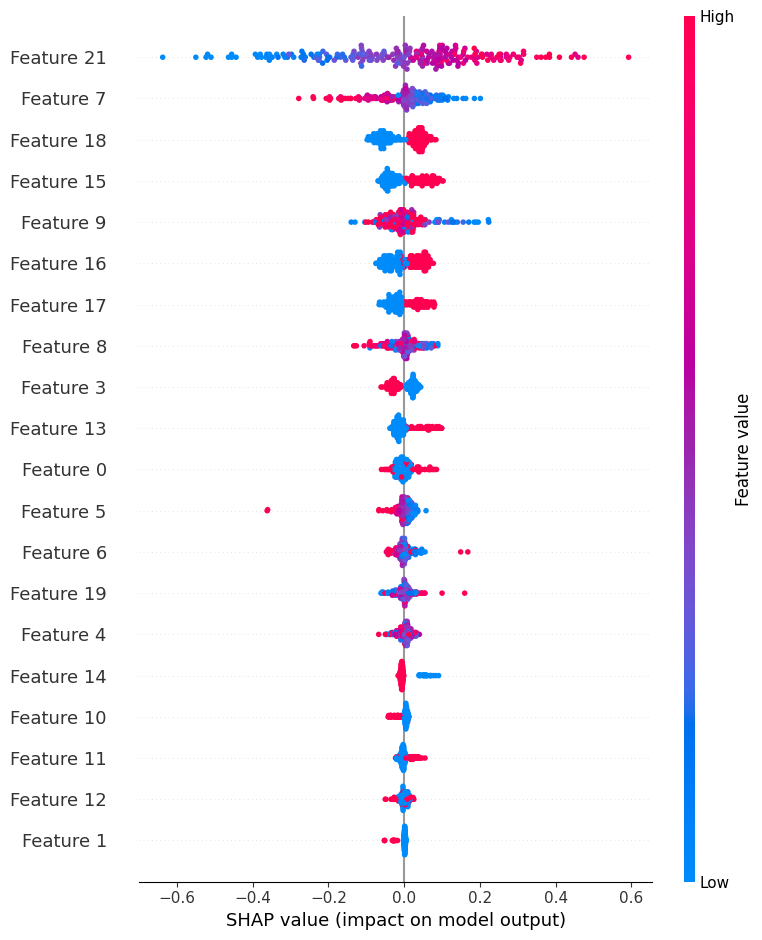

In [3]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Load your trained models (already trained)
# Assume you have:
# - linreg_model
# - rf_model
# - X_train_df (your feature matrix for training)
# - X_test_df (your test feature matrix)


# --- Linear Model SHAP ---
model = wrapper
# Use TreeExplainer for random forest
#explainer = shap.TreeExplainer(model)
#explainer = shap.KernelExplainer(lambda x: model.predict(x), X_train)
explainer = shap.GradientExplainer(model, X_val)


# Calculate SHAP values
shap_values = explainer.shap_values(X_val)

# Visualize SHAP summary plot for random forest
shap.summary_plot(shap_values, X_val)


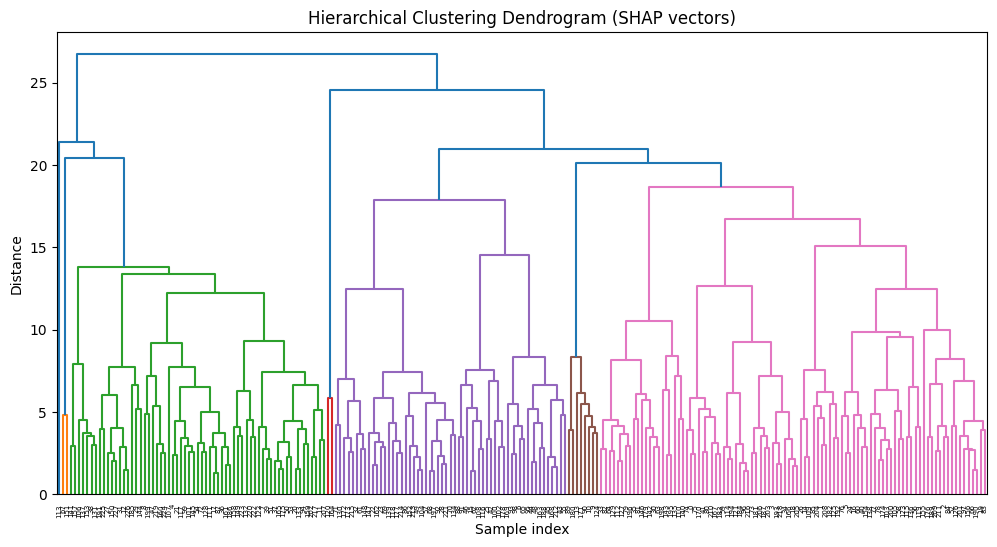

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

# Assume you already have:
# shap_matrix = SHAP values, shape (n_samples, n_features)
# From your earlier steps:
shap_matrix = shap_values   # (or shap_values_rf for random forest)

# If your shap_matrix is not standardized, standardize it (optional but often improves clustering)
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

# --- Step 1: Perform hierarchical clustering ---
# 'ward' linkage + Euclidean distance
Z = linkage(shap_matrix_scaled, method='ward', metric='euclidean')

# --- Step 2: Plot dendrogram to visualize ---
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (SHAP vectors)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# --- Step 3: Cut dendrogram into clusters ---
n_clusters = 3
height = 5
#cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
cluster_labels = fcluster(Z, t=height, criterion='distance')

# Now:
# cluster_labels is a (n_samples,) array assigning each sample to a cluster 1, 2, 3


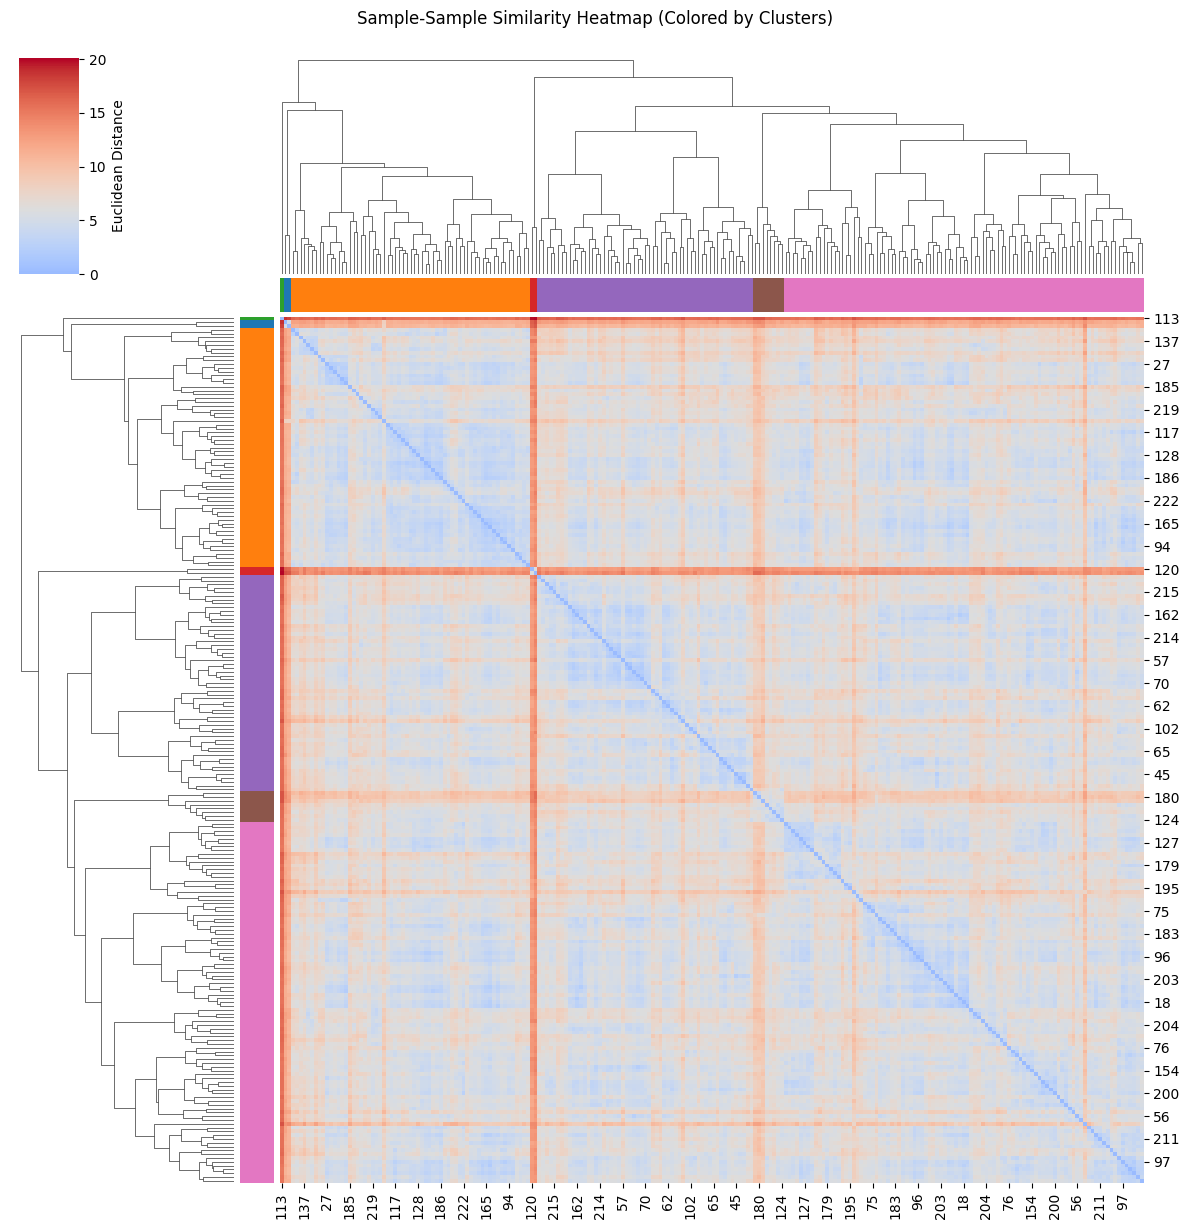

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler

# --- Assume you have your shap_matrix (n_samples, n_features) ---

# Step 1: Standardize SHAP values
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

# Step 2: Compute pairwise distances
pairwise_distances = pdist(shap_matrix_scaled, metric='euclidean')
distance_matrix = squareform(pairwise_distances)

# Step 3: Hierarchical clustering
Z = linkage(pairwise_distances, method='ward')

# Step 4: Cut tree into clusters
n_clusters = 3
height = 20
#cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
cluster_labels = fcluster(Z, t=height, criterion='distance')
n_clusters = len(cluster_labels)
# Step 5: Assign colors to cluster labels
palette = sns.color_palette("tab10", n_clusters)
cluster_color_mapping = dict(zip(np.unique(cluster_labels), palette))
row_colors = pd.Series(cluster_labels).map(cluster_color_mapping).to_numpy()

# Step 6: Create clustermap
sns.clustermap(distance_matrix,
                   row_linkage=Z,
                   col_linkage=Z,
                   row_colors=row_colors,
                   col_colors=row_colors,
                   cmap='coolwarm',  # <- makes sure the HEATMAP (distance matrix) is coolwarm!
                   center=np.median(distance_matrix),  # Centering at median distance
                   figsize=(12, 12),
                   cbar_kws={"label": "Euclidean Distance"})

plt.suptitle('Sample-Sample Similarity Heatmap (Colored by Clusters)', y=1.02)
plt.show()


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


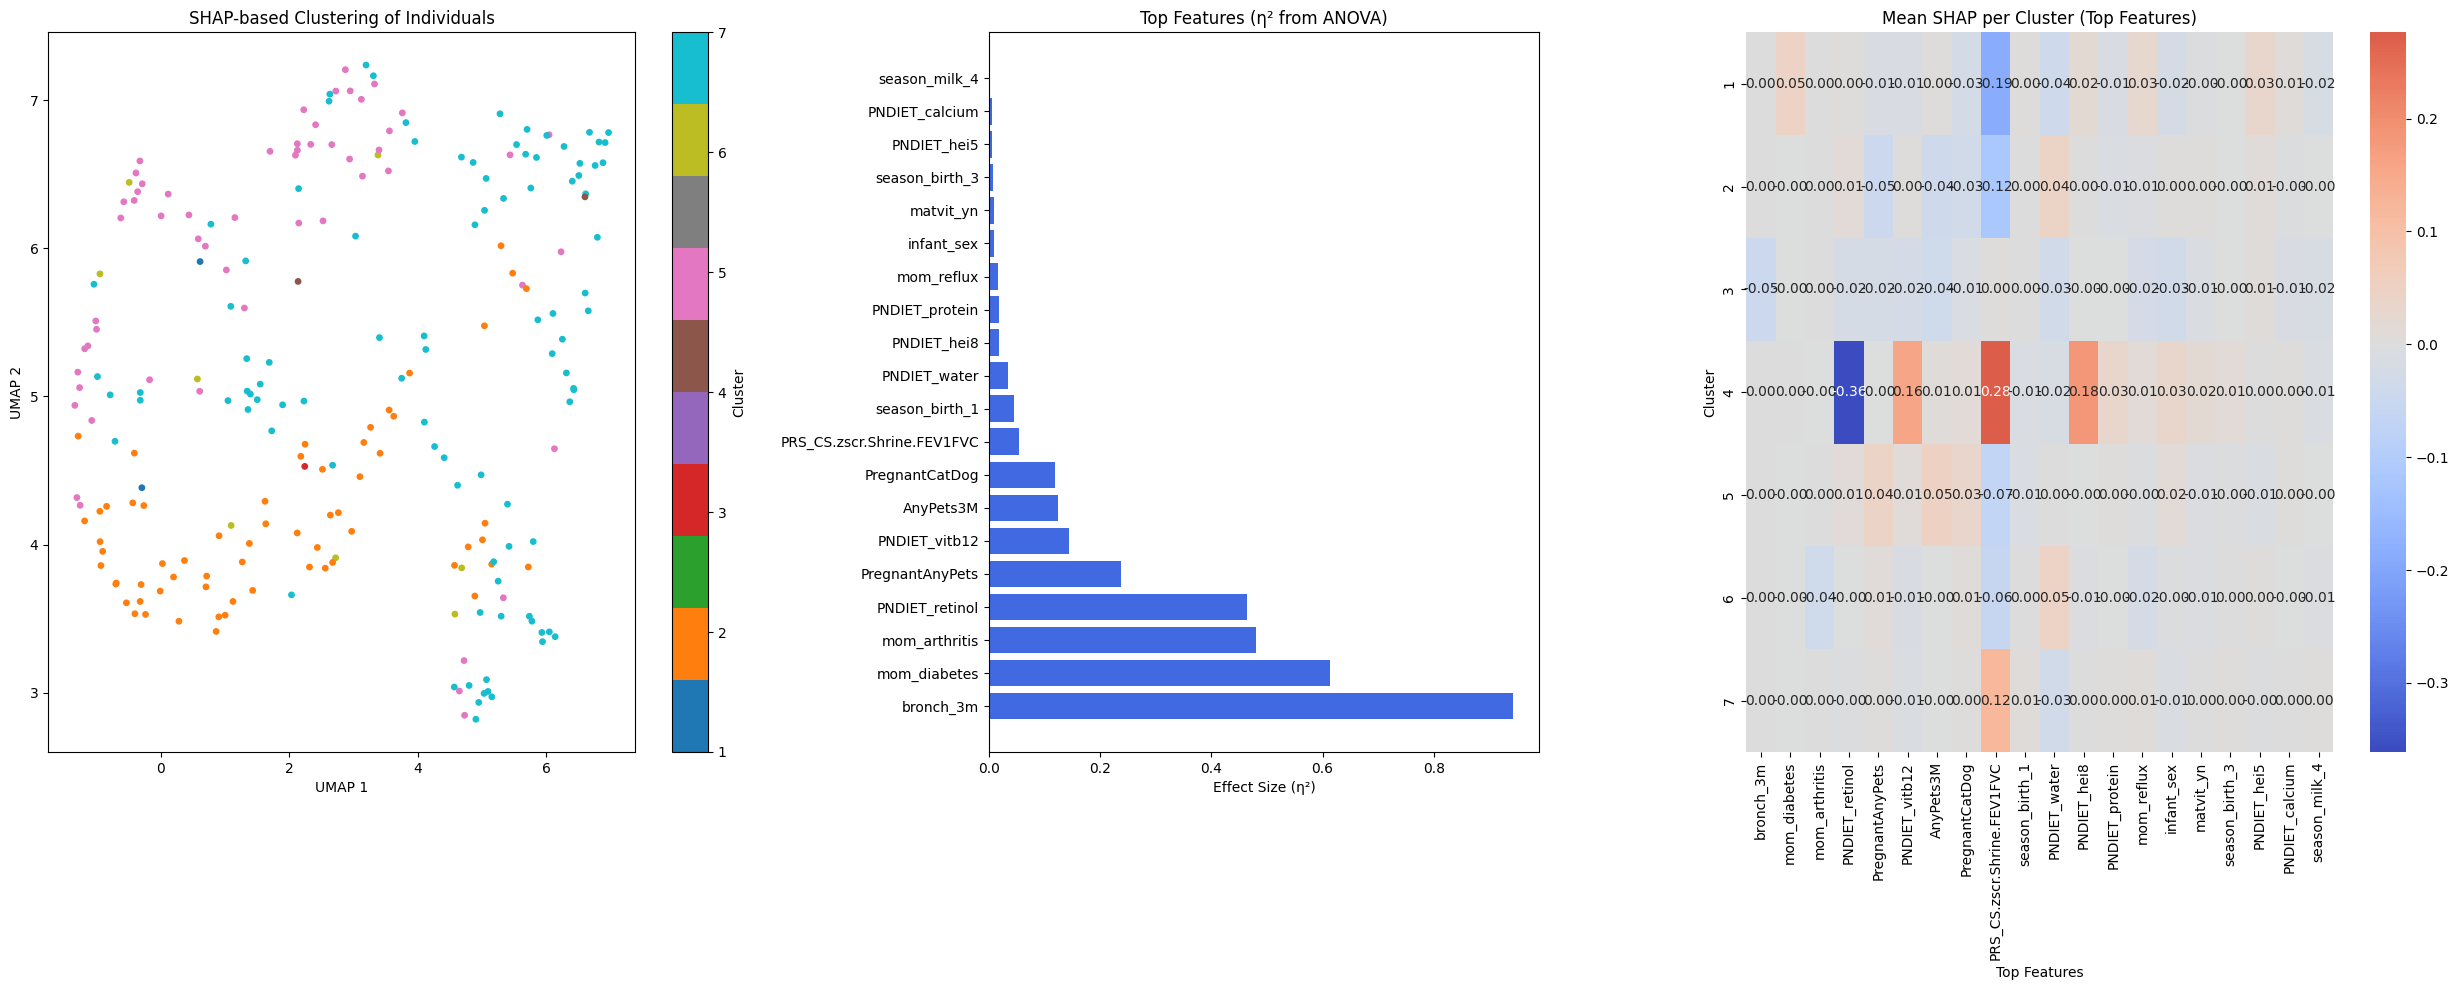

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
import seaborn as sns

# --- Assume you have already done ---
# - shap_matrix: (n_samples, n_features)
# - cluster_labels: array (n_samples,)
# - X_test.columns: feature names list

# If UMAP available
try:
    from umap import UMAP
    umap_model = UMAP(random_state=42)
    shap_umap = umap_model.fit_transform(shap_matrix)
except ImportError:
    print("UMAP not installed, falling back to PCA")
    pca = PCA(n_components=2)
    shap_umap = pca.fit_transform(shap_matrix)

# --- Step 1: ANOVA (feature selection based on η²) ---
F_values, p_values = f_classif(shap_matrix, cluster_labels)
eta_squared = F_values / (F_values + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# Sort features by η² descending
feature_names = X_val_df.columns.tolist()
sorted_idx = np.argsort(-eta_squared)
top_features = np.array(feature_names)[sorted_idx][:20]
top_eta2 = eta_squared[sorted_idx][:20]

# --- Step 2: Mean SHAP per cluster (for heatmap) ---
cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

# --- Step 3: Make Combined Figure ---

fig, axs = plt.subplots(1, 3, figsize=(25, 10), gridspec_kw={'width_ratios': [2, 1.5, 2]})

# --- Panel 1: UMAP scatter ---
sc = axs[0].scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=15)
axs[0].set_title('SHAP-based Clustering of Individuals')
axs[0].set_xlabel('UMAP 1')
axs[0].set_ylabel('UMAP 2')
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label('Cluster')

# --- Panel 2: Barplot of Top η² Features ---
axs[1].barh(top_features[::-1], top_eta2[::-1], color='royalblue')
axs[1].set_title('Top Features (η² from ANOVA)')
axs[1].set_xlabel('Effect Size (η²)')
axs[1].invert_yaxis()  # Highest on top

# --- Panel 3: Heatmap of Mean SHAP Values ---
sns.heatmap(mean_shap_by_cluster[top_features], cmap='coolwarm', center=0,
            annot=True, fmt=".2f", ax=axs[2])
axs[2].set_title('Mean SHAP per Cluster (Top Features)')
axs[2].set_xlabel('Top Features')
axs[2].set_ylabel('Cluster')

plt.tight_layout()
plt.show()


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


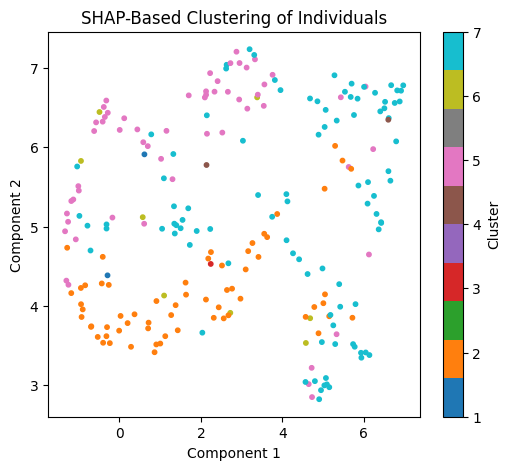

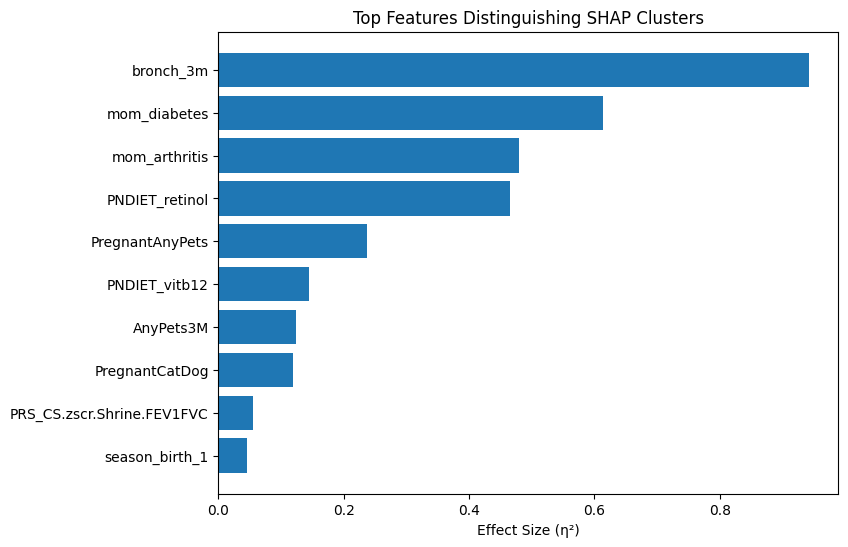

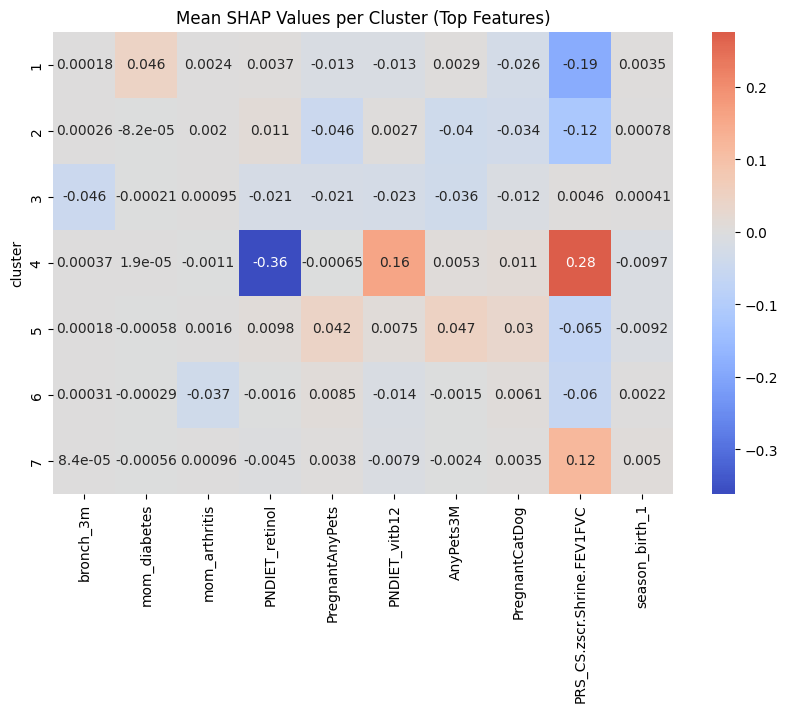

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.feature_selection import f_classif

# Assume:
# - shap_matrix (n_samples, n_features)
# - cluster_labels (n_samples,)

# --- Step 2: Project SHAP vectors into 2D for visualization ---

# Option 1: PCA
pca = PCA(n_components=2)
shap_pca = pca.fit_transform(shap_matrix)

# Option 2 (better): UMAP
try:
    from umap import UMAP
    umap_model = UMAP(random_state=42)
    shap_umap = umap_model.fit_transform(shap_matrix)
except ImportError:
    shap_umap = shap_pca  # fallback to PCA if UMAP not available

# --- Step 3: Scatter plot colored by cluster ---

plt.figure(figsize=(6, 5))
plt.scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title('SHAP-Based Clustering of Individuals')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label="Cluster")
plt.show()

# --- Step 4: One-way ANOVA across clusters to find η² for each feature ---

# f_classif returns (F-values, p-values)
F_values, p_values = f_classif(shap_matrix, cluster_labels)

# η² (eta squared) = between-group variability / total variability
eta_squared = F_values / (F_values + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# --- Step 5: Rank features by η² and plot ---

# Sort by eta_squared descending
feature_names = X_val_df.columns.tolist()  # or however you have feature names
sorted_idx = np.argsort(-eta_squared)
top_features = np.array(feature_names)[sorted_idx][:10]
top_eta2 = eta_squared[sorted_idx][:10]

# Barplot of top features
plt.figure(figsize=(8, 6))
plt.barh(top_features[::-1], top_eta2[::-1])
plt.xlabel('Effect Size (η²)')
plt.title('Top Features Distinguishing SHAP Clusters')
plt.show()

# --- Step 6: Average SHAP profiles per cluster ---

cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels

# Group by cluster
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

# Heatmap of average SHAP values
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(mean_shap_by_cluster.loc[:, top_features], annot=True, cmap='coolwarm', center=0)
plt.title('Mean SHAP Values per Cluster (Top Features)')
plt.show()


divide by zero encountered in divide
invalid value encountered in divide


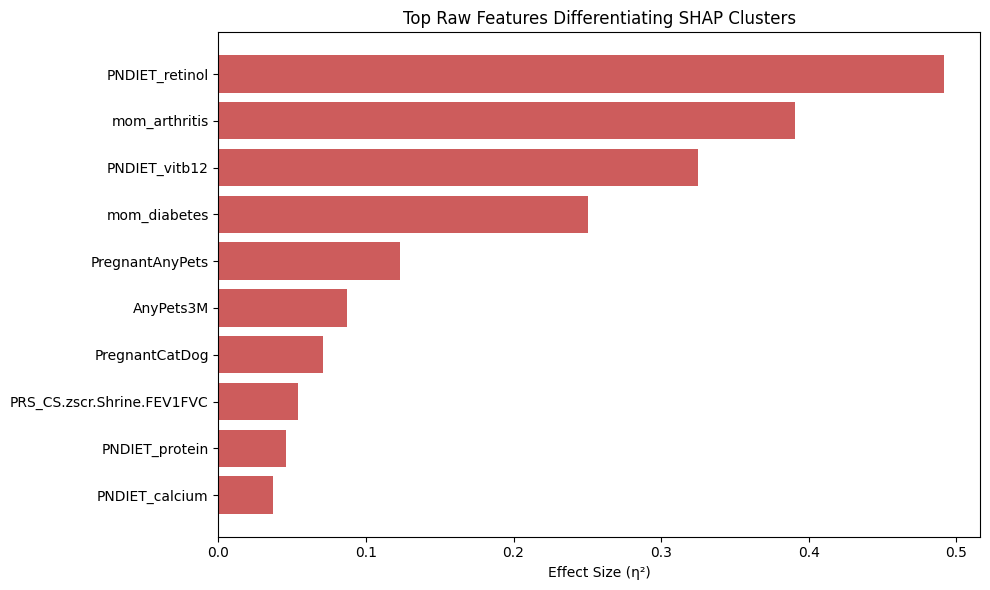

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

# Step 0: Prepare data
X_original = X_val_df.copy()
X_original['cluster'] = cluster_labels  # attach cluster labels temporarily

# Step 1: Run ANOVA across clusters on raw features
features_only = X_original.drop(columns='cluster')  # just input features
cluster_labels = np.array(cluster_labels).astype(int)  # ensure categorical

F_vals_feat, p_vals_feat = f_classif(features_only, cluster_labels)
n_clusters = len(np.unique(cluster_labels))
eta_squared_feat = F_vals_feat / (F_vals_feat + features_only.shape[0] - n_clusters)

# Step 2: Compute mean raw feature values per cluster
feature_df = X_val_df.copy()  # original input features
feature_df['cluster'] = cluster_labels
mean_feature_by_cluster = feature_df.groupby('cluster').mean()

# Step 3: Rank by η²
feature_names = features_only.columns.tolist()
sorted_idx_feat = np.argsort(-eta_squared_feat)
top_features_feat = np.array(feature_names)[sorted_idx_feat][:10]
top_eta2_feat = eta_squared_feat[sorted_idx_feat][:10]

# Step 4: Barplot
plt.figure(figsize=(10, 6))
plt.barh(top_features_feat[::-1], top_eta2_feat[::-1], color='indianred')
plt.xlabel('Effect Size (η²)')
plt.title('Top Raw Features Differentiating SHAP Clusters')
plt.tight_layout()
plt.show()


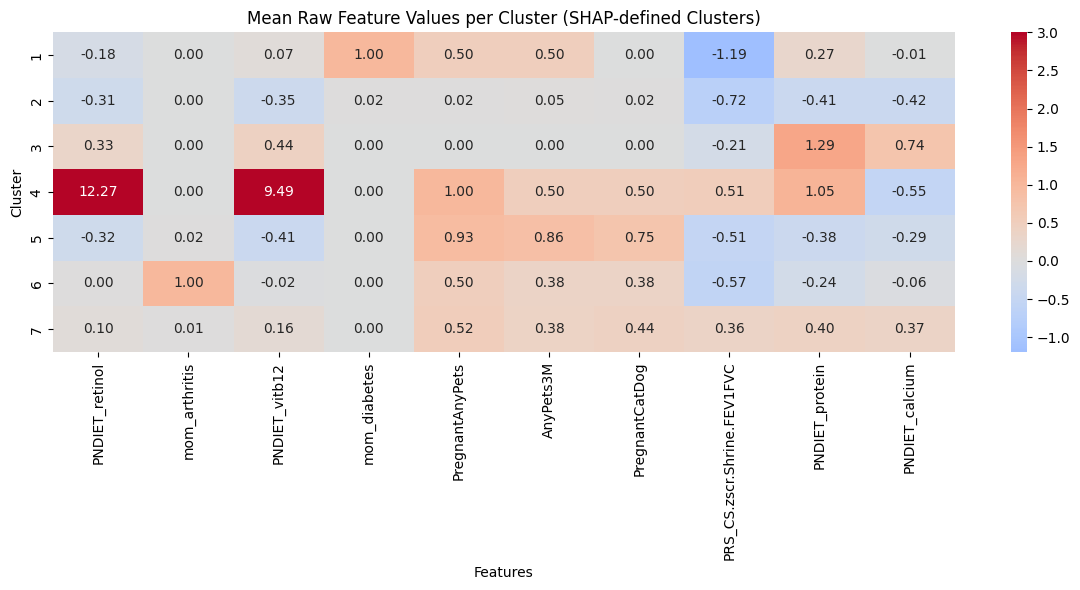

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Create a DataFrame of feature values and cluster labels ---
feature_df = X_val_df.copy()  # your original input features
feature_df['cluster'] = cluster_labels

# --- Step 2: Compute the mean feature values per cluster ---
mean_feature_by_cluster = feature_df.groupby('cluster').mean()

# --- Step 3: Select top differentiating features (optional, from previous ANOVA on feature values) ---
# You already computed `top_features_feat` in the previous cell (features with high η² based on raw values)

# If not, you can simply use all features:
# selected_features = mean_feature_by_cluster.columns.tolist()
selected_features = top_features_feat  # from previous step: top 20 or so

# --- Step 4: Plot heatmap of mean raw feature values per cluster ---
plt.figure(figsize=(12, 6))
sns.heatmap(mean_feature_by_cluster[selected_features], annot=True, fmt=".2f",
            cmap='coolwarm', center=0, vmax=3)

plt.title('Mean Raw Feature Values per Cluster (SHAP-defined Clusters)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()


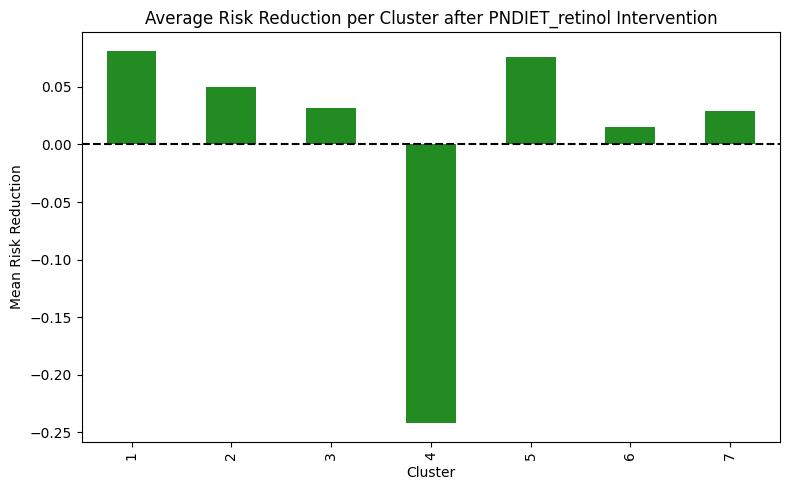

In [33]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Assumptions ---
# model: your loaded SimpleMLP model (on CPU or GPU)
# X_test: a pandas DataFrame (already scaled!)
# cluster_labels: 1D array-like of cluster assignments (same length as X_test)
# intervention_feature: string, one column in X_test
# new_value: float, the healthier target value

# Step 1: Choose the feature and value
intervention_feature = 'PNDIET_retinol'
new_value = 1.6

# Step 2: Apply intervention
X_test_intervened = X_val_df.copy()
X_test_intervened[intervention_feature] = new_value

# Step 3: Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor_original = torch.tensor(X_val_df.values, dtype=torch.float32).to(device)
X_tensor_intervened = torch.tensor(X_test_intervened.values, dtype=torch.float32).to(device)

# Step 4: Predict using the model
model.eval()
with torch.no_grad():
    y_pred_original = model(X_tensor_original).cpu().numpy().flatten()
    y_pred_intervened = model(X_tensor_intervened).cpu().numpy().flatten()

# Step 5: Calculate risk reduction
risk_reduction = y_pred_original - y_pred_intervened

# Step 6: Aggregate by cluster
result_df = pd.DataFrame({
    'cluster': cluster_labels,
    'risk_reduction': risk_reduction
})
cluster_risk_reduction = result_df.groupby('cluster')['risk_reduction'].mean()

# Step 7: Plot
plt.figure(figsize=(8, 5))
cluster_risk_reduction.plot(kind='bar', color='forestgreen')
plt.title(f'Average Risk Reduction per Cluster after {intervention_feature} Intervention')
plt.xlabel('Cluster')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


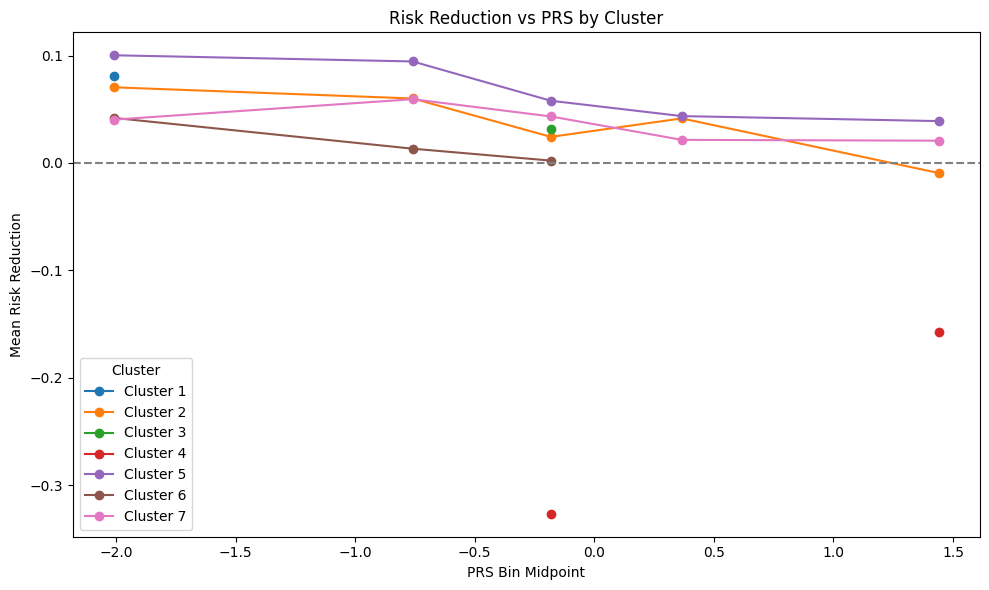

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate risk reduction (from previous code)
risk_reduction = y_pred_original - y_pred_intervened

# Step 2: Create a results DataFrame
result_df = X_val_df.copy()
result_df['cluster'] = cluster_labels
result_df['risk_reduction'] = risk_reduction
result_df['PRS'] = X_val_df['PRS_CS.zscr.Shrine.FEV1FVC']  # replace with your actual PRS column name

# Step 3: Bin PRS into quantiles or fixed-width bins
num_bins = 5
result_df['PRS_bin'] = pd.qcut(result_df['PRS'], q=num_bins, duplicates='drop')

# Step 4: Group by PRS_bin and cluster, then take mean
grouped = result_df.groupby(['PRS_bin', 'cluster'])['risk_reduction'].mean().reset_index()

# Convert PRS_bin to string midpoint for plotting (or keep as categorical for clean tick labels)
grouped['PRS_mid'] = grouped['PRS_bin'].apply(lambda b: b.mid)

# Step 5: Pivot for plotting
plot_df = grouped.pivot(index='PRS_mid', columns='cluster', values='risk_reduction')

# Step 6: Plot each cluster as a line
plt.figure(figsize=(10, 6))
for cluster in plot_df.columns:
    plt.plot(plot_df.index, plot_df[cluster], label=f'Cluster {cluster}', marker='o')

plt.title('Risk Reduction vs PRS by Cluster')
plt.xlabel('PRS Bin Midpoint')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


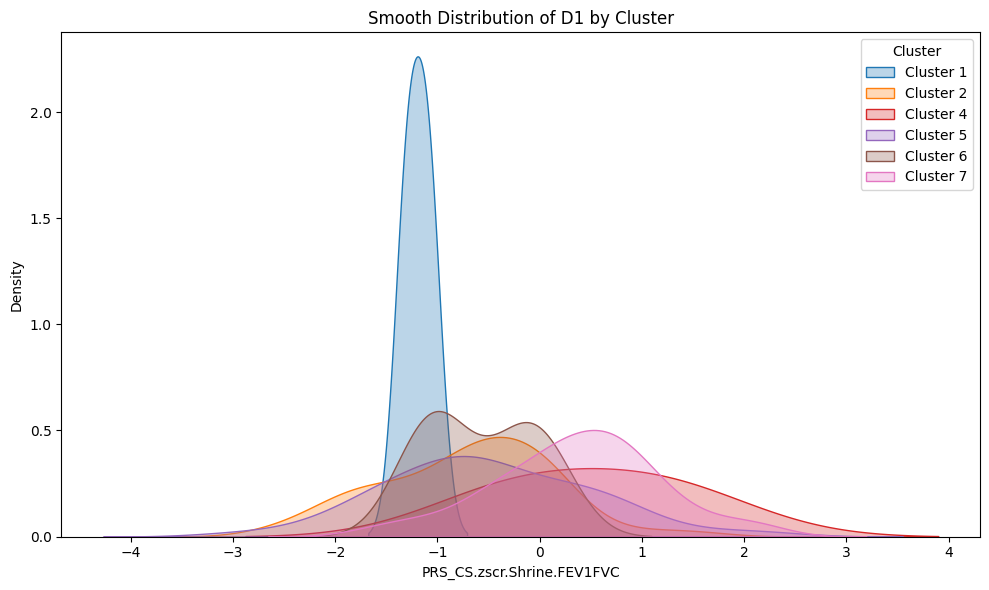

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare DataFrame ---
plot_df = X_val_df.copy()
plot_df['cluster'] = cluster_labels
plot_df['PRS_CS.zscr.Shrine.FEV1FVC'] = X_val_df['PRS_CS.zscr.Shrine.FEV1FVC']  # ensure this is the correct column

# --- Plot KDE for each cluster ---
plt.figure(figsize=(10, 6))
for cluster in sorted(plot_df['cluster'].unique()):
    subset = plot_df[plot_df['cluster'] == cluster]
    sns.kdeplot(subset['PRS_CS.zscr.Shrine.FEV1FVC'], label=f'Cluster {cluster}', fill=True, alpha=0.3)

plt.title('Smooth Distribution of D1 by Cluster')
plt.xlabel('PRS_CS.zscr.Shrine.FEV1FVC')
plt.ylabel('Density')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
